# Kaggle Surface Crack Detection 프로젝트

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arunrk7/surface-crack-detection")

print("Path to dataset files:", path)

100%|██████████| 233M/233M [00:21<00:00, 11.6MB/s] 

Extracting files...


Path to dataset files: C:\Users\skygr\.cache\kagglehub\datasets\arunrk7\surface-crack-detection\versions\1


In [2]:
import os

ROOT_DIR = './datafile'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'surface_crack')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

label_name_list = os.listdir(DATA_ROOT_DIR)
print(label_name_list)

for label_name in label_name_list:
    label_dir = os.path.join(DATA_ROOT_DIR, label_name)
    print('train label: '+ label_name+' => ', len(os.listdir(os.path.join(DATA_ROOT_DIR, label_name))))

['Negative', 'Positive']
train label: Negative =>  20000
train label: Positive =>  20000


In [3]:
import shutil

try:
    shutil.copytree(DATA_ROOT_DIR, TRAIN_DATA_ROOT_DIR)
except Exception as err:
    print(str(err))

In [4]:
if not os.path.exists(TEST_DATA_ROOT_DIR):
    os.mkdir(TEST_DATA_ROOT_DIR)
if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, 'Positive')):
    os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'Positive'))
if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, 'Negative')):
    os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'Negative'))

In [5]:
if not os.path.exists(os.path.join(DATA_ROOT_DIR, 'test_image_file')):
    os.mkdir(os.path.join(DATA_ROOT_DIR, 'test_image_file'))

In [6]:
import random

MOVE_RATIO = 0.2
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    train_data_file_list = os.listdir(src_dir_path)
    random.shuffle(train_data_file_list)
    SPLIT_NUMS = int(MOVE_RATIO*len(train_data_file_list))
    test_data_file_list = train_data_file_list[:SPLIT_NUMS]

    for test_data_file in test_data_file_list:
        try:
            shutil.move(os.path.join(src_dir_path, test_data_file), 
                        os.path.join(dst_dir_path, test_data_file))
        except Exception as err:
            print(str(err))

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
IMG_WIDTH, IMG_HEIGHT = 128, 128

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32, 
                                                    color_mode='rgb', class_mode='sparse', 
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                    subset='training')
validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32, 
                                                              color_mode='rgb', class_mode='sparse', 
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                              subset='validation')
test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size=32, 
                                                  color_mode='rgb', class_mode='sparse', 
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT))

print(train_generator.class_indices, train_generator.num_classes)

Found 25600 images belonging to 2 classes.
Found 6400 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
{'Negative': 0, 'Positive': 1} 2


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAvgPool2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

class_nums = train_generator.num_classes

model = Sequential([
    Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same', 
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)), 
    MaxPool2D(pool_size=(2, 2)), 
    Dropout(0.25), 
    
    Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'), 
    MaxPool2D(pool_size=(2, 2)), 
    Dropout(0.25), 

    Conv2D(kernel_size=(3, 3), filters=128, activation='relu', padding='same'), 
    MaxPool2D(pool_size=(2, 2)), 
    Dropout(0.25), 

    GlobalAvgPool2D(), 
    Dense(512, activation='relu'), 
    Dropout(0.5), 
    Dense(class_nums, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-4), metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0

In [ ]:
data, label = train_generator.next()

print(data.shape, label.shape)
print(data)     # print(data[i][0, 0, :]) 즉, 첫 번째 픽셀의 R, G, B 값 출력
print(label)

# print(data[i])를 하면, numpy는 기본적으로 마지막 차원(채널 차원)을 출력에서 축소해서 표시한다.

(32, 128, 128, 3) (32,)
[[[[0.78823537 0.7803922  0.72156864]
   [0.7803922  0.7725491  0.7137255 ]
   [0.7725491  0.76470596 0.7058824 ]
   ...
   [0.81568635 0.8078432  0.7568628 ]
   [0.80392164 0.7960785  0.74509805]
   [0.8078432  0.8000001  0.7490196 ]]

  [[0.76470596 0.7568628  0.69803923]
   [0.7725491  0.76470596 0.7058824 ]
   [0.77647066 0.7686275  0.70980394]
   ...
   [0.81568635 0.8078432  0.7568628 ]
   [0.8117648  0.80392164 0.75294125]
   [0.8117648  0.80392164 0.75294125]]

  [[0.76470596 0.7568628  0.69803923]
   [0.7803922  0.7725491  0.7137255 ]
   [0.79215693 0.7843138  0.7254902 ]
   ...
   [0.8196079  0.8117648  0.7607844 ]
   [0.8235295  0.81568635 0.76470596]
   [0.8235295  0.81568635 0.76470596]]

  ...

  [[0.7725491  0.7607844  0.7019608 ]
   [0.74509805 0.73333335 0.6745098 ]
   [0.7490196  0.7372549  0.6784314 ]
   ...
   [0.8078432  0.8000001  0.7490196 ]
   [0.7843138  0.77647066 0.7254902 ]
   [0.7686275  0.7607844  0.70980394]]

  [[0.77647066 0.7450

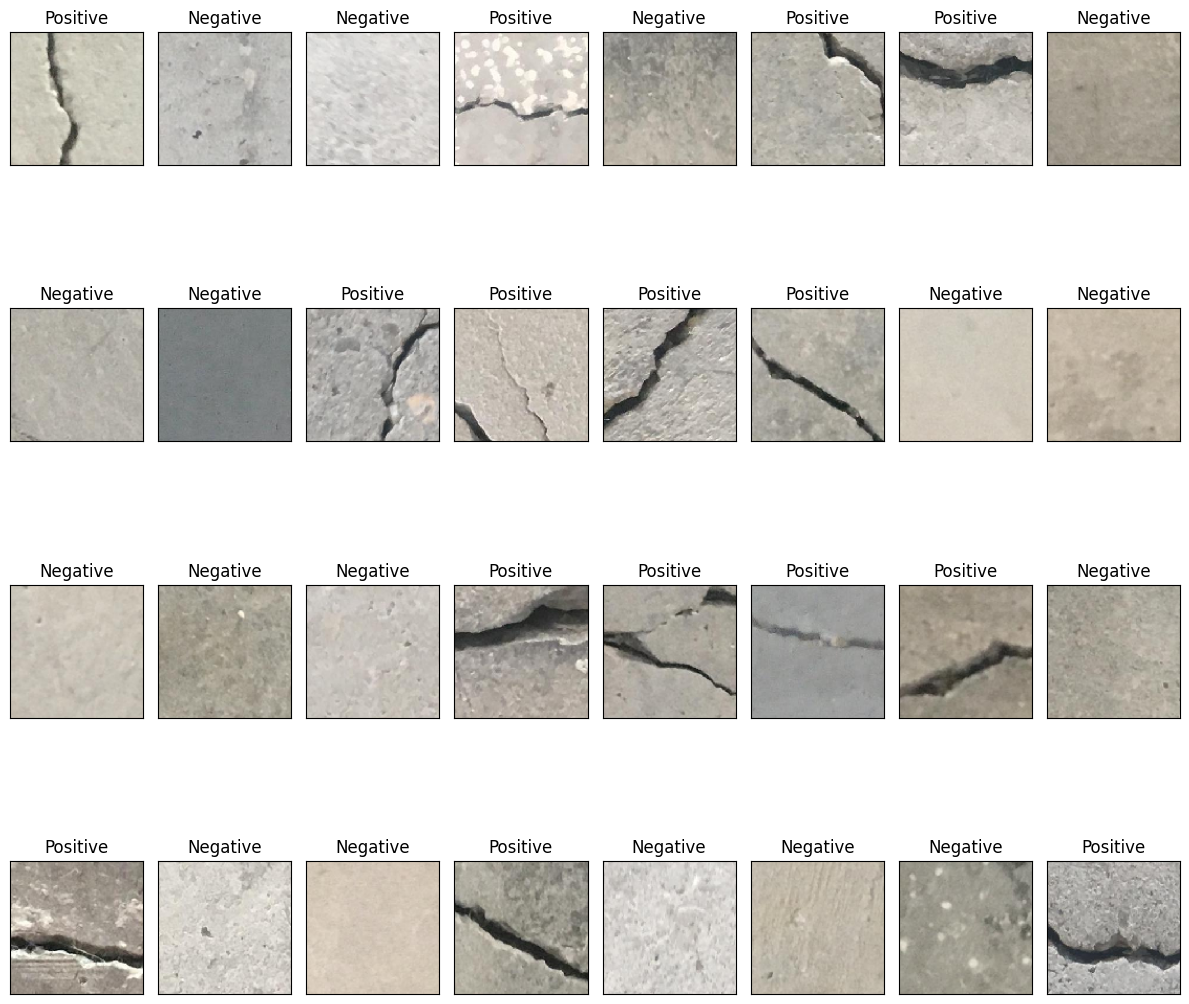

In [ ]:
import matplotlib.pyplot as plt

class_dic = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(12, 12))

for i in range(len(label)):
    plt.subplot(4, 8, i+1)
    plt.title(str(class_dic[label[i]]))
    plt.xticks([]), plt.yticks([])      # x, y축 눈금 표시x
    plt.imshow(data[i])
plt.tight_layout()
plt.show()

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
hist = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[stopping])

Epoch 1/30
800/800 [==============================] - 184s 219ms/step - loss: 0.4050 - acc: 0.7891 - val_loss: 0.1264 - val_acc: 0.9700
Epoch 2/30
800/800 [==============================] - 32s 40ms/step - loss: 0.0926 - acc: 0.9712 - val_loss: 0.0874 - val_acc: 0.9770
Epoch 3/30
800/800 [==============================] - 23s 29ms/step - loss: 0.0728 - acc: 0.9779 - val_loss: 0.0710 - val_acc: 0.9836
Epoch 4/30
800/800 [==============================] - 23s 29ms/step - loss: 0.0643 - acc: 0.9808 - val_loss: 0.0677 - val_acc: 0.9833
Epoch 5/30
800/800 [==============================] - 23s 29ms/step - loss: 0.0625 - acc: 0.9805 - val_loss: 0.0656 - val_acc: 0.9828
Epoch 6/30
800/800 [==============================] - 23s 29ms/step - loss: 0.0559 - acc: 0.9822 - val_loss: 0.0559 - val_acc: 0.9847
Epoch 7/30
800/800 [==============================] - 22s 28ms/step - loss: 0.0515 - acc: 0.9831 - val_loss: 0.0676 - val_acc: 0.9828
Epoch 8/30
800/800 [==============================] - 22s 28

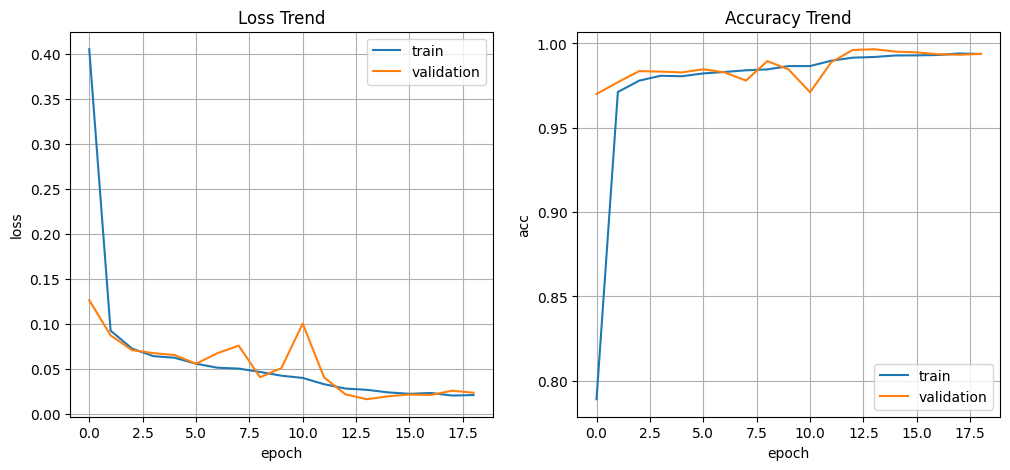

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.legend(loc='best')
plt.grid()

plt.show()